In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.data.loader import DataLoader
from src.data.preprocessor import DataPreprocessor


In [2]:
d = DataLoader(os.path.join(project_root, "data/processed"))

d.load_data("train.csv", "test.csv")
train_df = d.train_data
test_df = d.test_data

In [3]:
train_df.shape, test_df.shape

((296000, 22), (111144, 22))

In [4]:
train_df['trans_date'], train_df['trans_time'] = zip(*train_df['trans_date_trans_time'].apply(lambda x: x.strip().split(' ')))
train_df.drop('trans_date_trans_time', axis=1, inplace=True)

test_df['trans_date'], test_df['trans_time'] = zip(*test_df['trans_date_trans_time'].apply(lambda x: x.strip().split(' ')))
test_df.drop('trans_date_trans_time', axis=1, inplace=True)

In [5]:
def detect_date_columns(df : pd.DataFrame, numerical: list[str]) -> list[str]:
    date_columns = []
    for col in df.columns:
        if col in numerical:
            continue
        try:
            temp_series = pd.to_datetime(df[col], errors="coerce")
            if temp_series.notna().any():
                date_columns.append(col)
        except Exception:
            pass
    return date_columns

def get_column_types(df : pd.DataFrame) -> tuple:
    # exclude target column 
    numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns.tolist()
    numerical_columns.remove("is_fraud")

    # exclude target column
    date_columns = detect_date_columns(df.copy(), numerical_columns)
    date_columns.remove("is_fraud")

    categorical_columns = [
        col
        for col in df.select_dtypes(include=["object"]).columns
        if col not in date_columns
    ]

    target_col = "is_fraud"

    return (
        numerical_columns,
        categorical_columns,
        date_columns,
        target_col
    )

In [6]:
train_numerical_columns, train_categorical_columns, train_date_columns, train_target_col = get_column_types(train_df)
test_numerical_columns, test_categorical_columns, test_date_columns, test_target_col = get_column_types(test_df)

/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/1232741884.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df[col], errors="coerce")
/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/1232741884.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df[col], errors="coerce")
/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/1232741884.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_series = pd.to_datetime(df[col], errors="coerce")
/var/folders/1m/mv4prtn17kd55ys

In [7]:
test_numerical_columns, test_categorical_columns, test_date_columns, test_target_col

(['cc_num',
  'amt',
  'zip',
  'lat',
  'long',
  'city_pop',
  'unix_time',
  'merch_lat',
  'merch_long'],
 ['merchant',
  'category',
  'first',
  'last',
  'gender',
  'street',
  'city',
  'state',
  'job',
  'trans_num'],
 ['dob', 'trans_date', 'trans_time'],
 'is_fraud')

In [8]:
pd.set_option('display.max_columns', 0)
test_df.head()

,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,trans_date,trans_time
0,377895991033232,"fraud_Bahringer, Schoen and Corkery",shopping_pos,1.07,Kimberly,Myers,F,6881 King Isle Suite 228,Higganum,CT,6441,41.4682,-72.5751,5438,"Librarian, academic",1964-11-17,cf581d75ccc9ba838a05dec8bfa78b5b,1375430128,41.240083,-71.837788,0,2020-08-02,07:55:28
1,30364087349027,"fraud_Romaguera, Wehner and Tromp",kids_pets,94.99,Samuel,Sandoval,M,0005 Morrison Land,Mounds,OK,74047,35.8896,-96.0887,7163,Fitness centre manager,1982-02-05,b1bfaf13224da41f422db483fd810dd7,1377266716,35.156537,-95.806648,0,2020-08-23,14:05:16
2,30328384440870,fraud_Berge-Hills,kids_pets,31.28,Helen,Campbell,F,182 Sergio Summit Apt. 129,Browning,MO,64630,40.0290,-93.1607,602,Cytogeneticist,1954-07-14,cde9fc0136873645778d0ad8817db655,1388247749,39.888665,-93.106804,0,2020-12-28,16:22:29
3,30364087349027,"fraud_Connelly, Reichert and Fritsch",gas_transport,73.06,Samuel,Sandoval,M,0005 Morrison Land,Mounds,OK,74047,35.8896,-96.0887,7163,Fitness centre manager,1982-02-05,90b8429191e5c83df1afba4e5db4d61e,1384425890,36.734101,-96.737345,0,2020-11-14,10:44:50
4,4198470814557,fraud_Kuphal-Predovic,misc_net,9.99,Christie,Williamson,F,519 Jerry Views,Avoca,IA,51521,41.4768,-95.3509,2036,Engineering geologist,1971-08-20,e4893795b6b3e41667129b9ed13b9650,1382147409,40.922072,-94.899388,0,2020-10-19,01:50:09


/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/2872726459.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x='category', y='fraud_rate', data=category_fraud, palette='viridis')


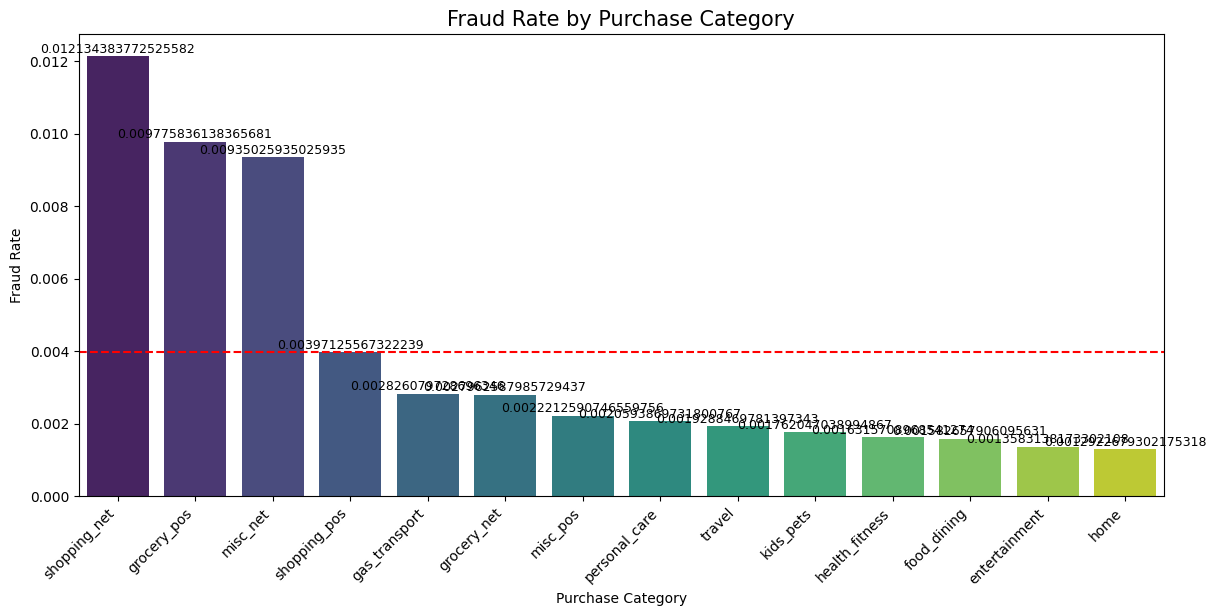

In [9]:
# Calculate fraud rate by category
category_fraud = train_df.groupby('category').agg(
    fraud_rate=('is_fraud', 'mean'),
    transaction_count=('is_fraud', 'count')
).sort_values('fraud_rate', ascending=False).reset_index()

plt.figure(figsize=(14, 6))
bar = sns.barplot(x='category', y='fraud_rate', data=category_fraud, palette='viridis')
plt.axhline(y=train_df['is_fraud'].mean(), color='red', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.title('Fraud Rate by Purchase Category', fontsize=15)
plt.xlabel('Purchase Category')
plt.ylabel('Fraud Rate')


for i, p in enumerate(bar.patches):
    count = category_fraud.iloc[i]['fraud_rate']
    bar.annotate(f'{count:,}', (p.get_x() + p.get_width()/2, p.get_height()+0.0001), 
                ha='center', fontsize=9)

<h5>
This graph shows, that shopping_net, grocery_pos and misc_net are categories with the highest fraud rate, totaling about 64000 fraudulent transactions
</h5>

/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/4066976487.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_fraud = train_df.groupby('age_group').agg(
/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/4066976487.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(x='age_group', y='fraud_rate', data=age_fraud, palette='Blues_d')


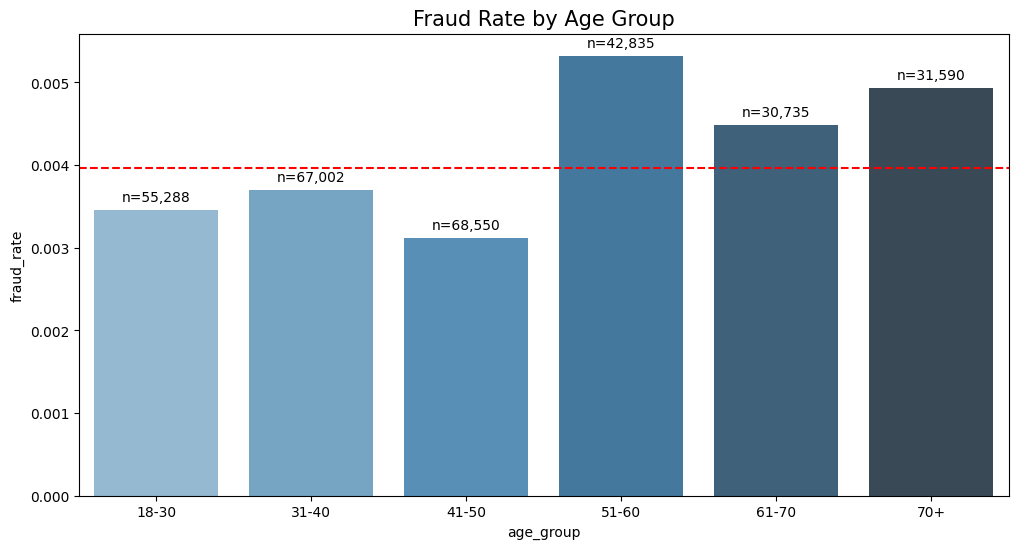

In [ ]:
train_df['age'] = (pd.to_datetime('2020-01-01') - pd.to_datetime(train_df['dob'])).dt.days / 365.25
train_df['age_group'] = pd.cut(train_df['age'], 
                              bins=[0, 30, 40, 50, 60, 70, 100],
                              labels=['18-30', '31-40', '41-50', '51-60', '61-70', '70+'])


age_fraud = train_df.groupby('age_group').agg(
    fraud_rate=('is_fraud', 'mean'),
    transaction_count=('is_fraud', 'count')
).reset_index()

plt.figure(figsize=(12, 6))
bar = sns.barplot(x='age_group', y='fraud_rate', data=age_fraud, palette='Blues_d')
plt.axhline(y=train_df['is_fraud'].mean(), color='red', linestyle='--')
plt.title('Fraud Rate by Age Group', fontsize=15)

for i, p in enumerate(bar.patches):
    bar.annotate(f'n={age_fraud.iloc[i]["transaction_count"]:,}', 
                (p.get_x() + p.get_width()/2, p.get_height() + 0.0001),
                ha='center')

<h5>
This graph shows, that people older than 50 years tend to be more vulnerable to fraud compared to younger age groups. This insight highlights the need for targeted fraud prevention measures for older populations 
</h5>

/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/3186428942.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['trans_hour'] = pd.to_datetime(train_df['trans_time']).dt.hour


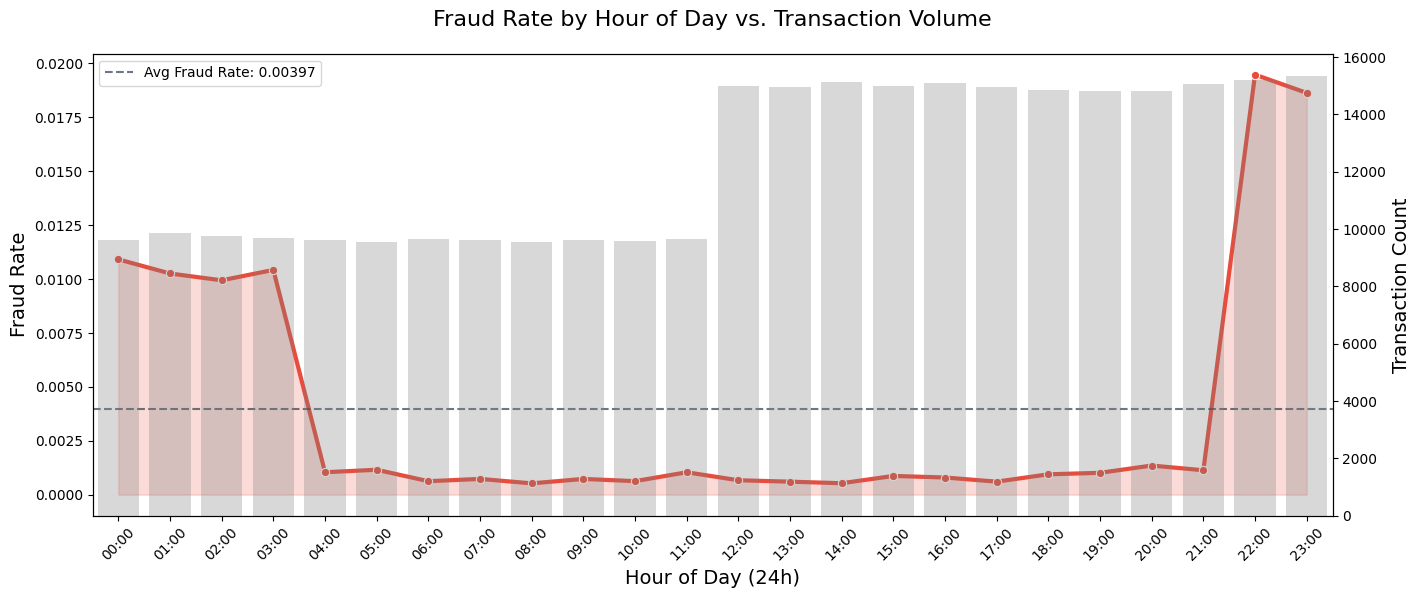

In [11]:
train_df['trans_hour'] = pd.to_datetime(train_df['trans_time']).dt.hour

train_df['trans_date'] = pd.to_datetime(train_df['trans_date'])
train_df['day_of_week'] = train_df['trans_date'].dt.dayofweek
train_df['day_name'] = train_df['trans_date'].dt.day_name()

hourly_fraud = train_df.groupby('trans_hour').agg(
    fraud_rate=('is_fraud', 'mean'),
    transaction_count=('is_fraud', 'count')
).reset_index()

dow_fraud = train_df.groupby(['day_of_week', 'day_name']).agg(
    fraud_rate=('is_fraud', 'mean'),
    transaction_count=('is_fraud', 'count')
).reset_index()

dow_fraud = dow_fraud.sort_values('day_of_week')

plt.figure(figsize=(16, 6))

ax = sns.lineplot(
    x='trans_hour',
    y='fraud_rate',
    data=hourly_fraud,
    marker='o',
    linewidth=3,
    color='#e74c3c'
)

plt.fill_between(
    hourly_fraud['trans_hour'],
    hourly_fraud['fraud_rate'],
    alpha=0.2,
    color='#e74c3c'
)

avg_fraud_rate = train_df['is_fraud'].mean()

# Reference line for average fraud rate
plt.axhline(
    y=avg_fraud_rate,
    color='#2c3e50',
    linestyle='--',
    alpha=0.7,
    label=f'Avg Fraud Rate: {avg_fraud_rate:.5f}'
)

ax2 = ax.twinx()
sns.barplot(
    x='trans_hour',
    y='transaction_count',
    data=hourly_fraud,
    ax=ax2,
    alpha=0.3,
    color='gray'
)
ax2.set_ylabel('Transaction Count', fontsize=14)
ax2.grid(False)

plt.title('Fraud Rate by Hour of Day vs. Transaction Volume', fontsize=16, pad=20)
ax.set_xlabel('Hour of Day (24h)', fontsize=14)
ax.set_ylabel('Fraud Rate', fontsize=14)
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f'{hour:02d}:00' for hour in range(0, 24)], rotation=45)
ax.legend(loc='upper left')

<h5>
The plot shows, that late-night and early-morning hours have higher fraud rates (up to 780% more) than the rest of the day
</h5>

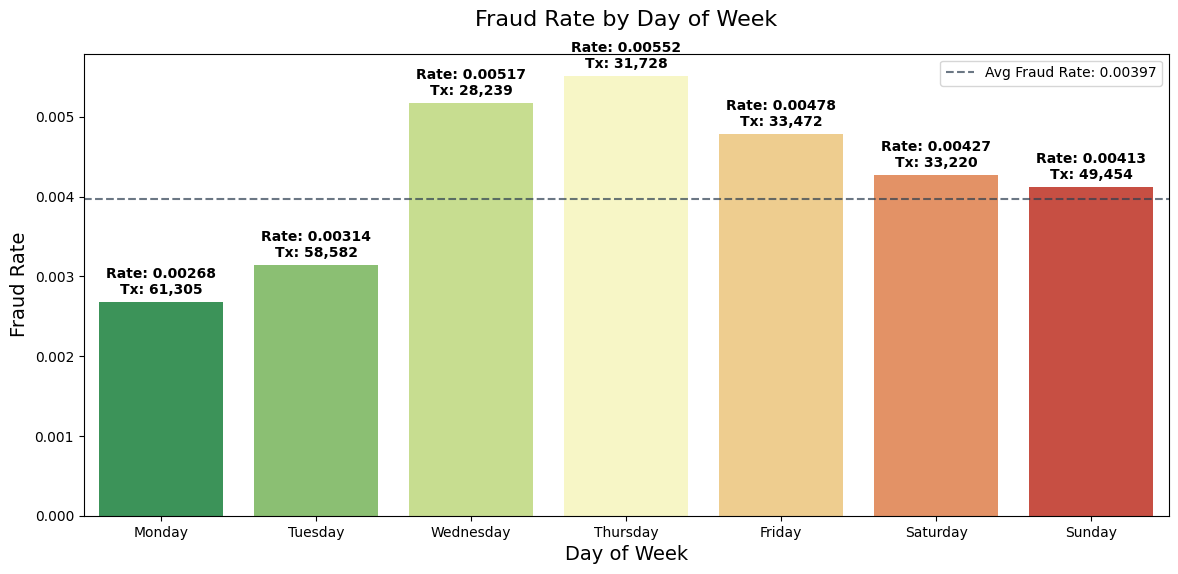

In [12]:
plt.figure(figsize=(14, 6))

ax = sns.barplot(
    x='day_name',
    y='fraud_rate',
    data=dow_fraud,
    hue = 'day_name',
    legend=False,
    order=dow_fraud['day_name'],
    palette='RdYlGn_r'
)

for i, row in enumerate(dow_fraud.itertuples()):
    ax.text(
        i,
        row.fraud_rate + 0.0001,
        f'Rate: {row.fraud_rate:.5f}\nTx: {row.transaction_count:,}',
        ha='center',
        fontweight='bold'
    )

# Reference line for average fraud rate
plt.axhline(
    y=avg_fraud_rate,
    color='#2c3e50',
    linestyle='--',
    alpha=0.7,
    label=f'Avg Fraud Rate: {avg_fraud_rate:.5f}'
)

plt.title('Fraud Rate by Day of Week', fontsize=16, pad=20)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Fraud Rate', fontsize=14)
plt.legend()

plt.show()

<h5>
The plot shows that certain days of the week have significantly different fraud rates, with weekend days (Saturday and Sunday) showing  higher fraud rates than weekdays. 
</h5>

<h5>
Thursdays in particular have the highest fraud rate of the week - while Mondays appear to have the lowest fraud occurrence. This pattern suggests fraudsters might be most active in the middle of the work week, perhaps taking advantage of when people are busiest with work responsibilities and might be less attentive to monitoring their accounts
</h5>

In [13]:
import folium
from folium.plugins import HeatMap

fraud_df = train_df[train_df['is_fraud'] == 1].copy()
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

heat_data = [[row['lat'], row['long']] for _, row in fraud_df.iterrows()]
HeatMap(heat_data, radius=15).add_to(m)

m

[Link to the file with the rendered map](https://nbviewer.org/github/ol1g3/fraud-detection-ML-pipeline/blob/notebooks_and_visuals/notebooks/data_exploration.ipynb)

<h5>
This plot shows than big cities have higher fraud count, including Washington, New York and Los Angeles having the highest number of fraudulent transcations
</h5>

/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/3253122769.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pop_fraud = train_df.groupby('population_band').agg(
/var/folders/1m/mv4prtn17kd55ys3sg9lwtp00000gq/T/ipykernel_42562/3253122769.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='population_band', y='fraud_rate', data=pop_fraud, palette='viridis')


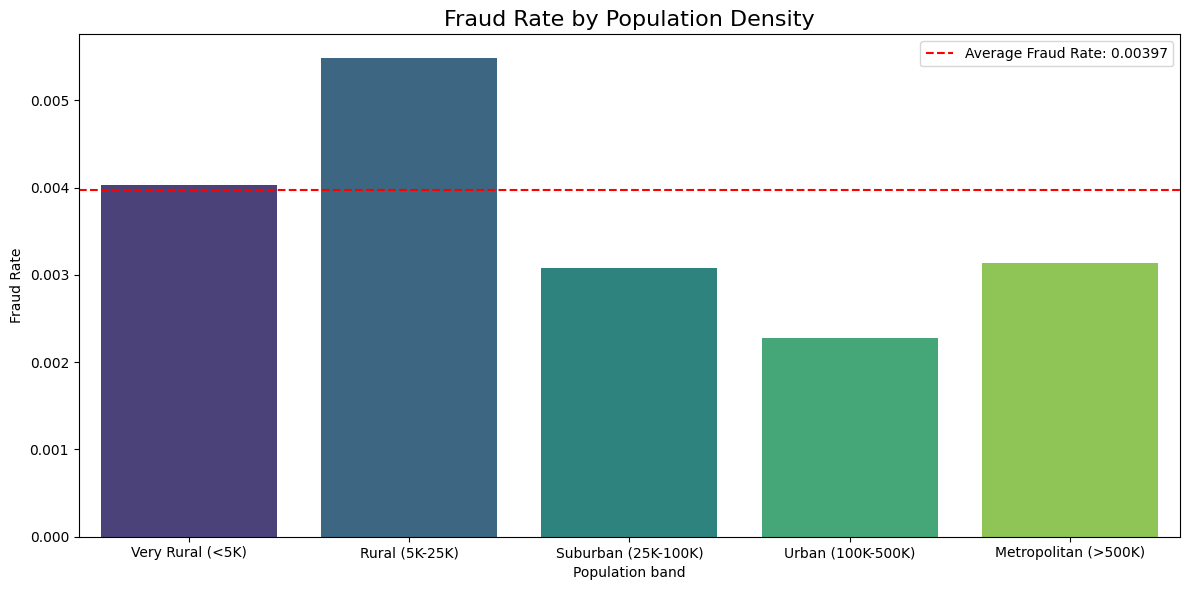

In [14]:
# Population bands for analysis
pop_bins = [0, 5000, 25000, 100000, 500000, float('inf')]
pop_labels = ['Very Rural (<5K)', 'Rural (5K-25K)', 'Suburban (25K-100K)', 
              'Urban (100K-500K)', 'Metropolitan (>500K)']

train_df['population_band'] = pd.cut(train_df['city_pop'], bins=pop_bins, labels=pop_labels)

pop_fraud = train_df.groupby('population_band').agg(
    fraud_rate=('is_fraud', 'mean'),
    transaction_count=('is_fraud', 'count'),
    fraud_count=('is_fraud', 'sum')
).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='population_band', y='fraud_rate', data=pop_fraud, palette='viridis')
plt.title('Fraud Rate by Population Density', fontsize=16)
plt.axhline(y=train_df['is_fraud'].mean(), color='red', linestyle='--', 
           label=f'Average Fraud Rate: {train_df["is_fraud"].mean():.5f}')
plt.legend()
plt.xlabel('Population band')
plt.ylabel('Fraud Rate')
plt.tight_layout()
plt.show()

<h5>
This plot shows that rural areas (with population between 5-25K) tend to have higher fraud rate (up to 37% more) than areas with population exceeding 25K. 
</h5>

<h5>
This suggests that fraudsters might be targeting less densely populated regions
</h5>